# Results

This notebook contains all the code and plots reported in the "Results" section of the ISMIR 2016 submitted paper:
"Tempo Estimation for Music Loops and a Simple Confidence Measure".


In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
seaborn.set(style="whitegrid")
%matplotlib inline
datasets = load_datasets(dirnames=None, clean=True, exclude_files=['analysis_freesound_extractor_04.json'])

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Overall accuracy



General tempo estimation results (FSL4)
****************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------------------------------------
Percival14   43.86         54.39        70.42        
Gkiokas12    18.16         35.58        65.46        
Bock15       22.69         37.07        65.08        
Degara12     30.34         53.08        60.65        
Zapata14     28.72         52.67        60.62        
RekBox       30.39         37.05        40.95        


General tempo estimation results (APPL)
****************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------------------------------------
Percival14   55.93         69.49        79.59        
Gkiokas12    27.85         58.36        78.46        
Degara12     31.32         66.78        78.25        
Zapata14     31.73         66.73        77.47        
Bock15       34.74         45.98        71.61        
RekBox       35.24  

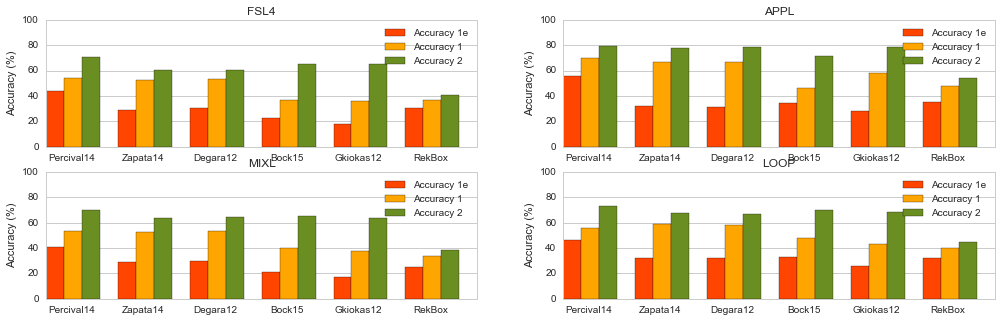


General tempo estimation results (ALL DATASETS)
-----------------------------------------------

Method       Accuracy 1e   Accuracy 1   Accuracy 2   Mean accuracy   
---------------------------------------------------------------------
Percival14   46.62         57.29        73.25        59.05           
Zapata14     31.37         58.17        67.42        52.32           
Degara12     31.68         58.03        67.21        52.31           
Bock15       29.93         45.46        69.21        48.20           
Gkiokas12    23.74         43.30        68.70        45.25           
RekBox       31.36         39.55        44.44        38.45           


In [2]:
fig1, axs = plt.subplots(2, 2, figsize=(17, 5))
all_datasets_method_results = dict()
for count, dataset in enumerate(datasets):
    print title("\nGeneral tempo estimation results (%s)" % dataset.short_name, c='*')
    methods_to_compare = ['Percival14_bpm', 'RE13m_bpm', 'RE13d_bpm', 'Madmom_bpm', 'Gkiokasq8_bpm', 'rekordbox_bpm']
    table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2']
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [TEMPO_ESTIMATION_ALGORITHM_NAMES[method]]
            for accuracy_func in accuracy1e, accuracy1, accuracy2:
                method_results = accuracy_func(dataset.data, method)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_rows.append(table_row)
        except IndexError:
            print "Warning: Skipping method %s (analsyis not found in dataset)" % method
            continue
    print ""
    print_table(table_header, table_rows, sort_column=3, highlight_max=True)
    
    ax = axs[count/2,count%2]
    N = len(methods_to_compare)
    ind = np.arange(N)
    accuracy_1e_means = [row[1] for row in table_rows]
    accuracy_1_means = [row[2] for row in table_rows]
    accuracy_2_means = [row[3] for row in table_rows]
    width = 0.25
    rects1 = ax.bar(ind, accuracy_1e_means, width, color=COLORS[0])
    rects2 = ax.bar(ind + width, accuracy_1_means, width, color=COLORS[1])
    rects3 = ax.bar(ind + 2*width, accuracy_2_means, width, color=COLORS[2])
    ax.set_title(dataset.short_name)
    ax.set_xticks(ind + 1.4 * width)
    ax.set_xticklabels([TEMPO_ESTIMATION_ALGORITHM_NAMES[method] for method in methods_to_compare], rotation=0)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy 1e', 'Accuracy 1', 'Accuracy 2'))
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)
    
fig1.savefig(os.path.join(settings.TEMPO_ESTIMATION_OUT_PATH, 'overall_accuracies.pdf'))
plt.show()

print title("General tempo estimation results (ALL DATASETS)")
table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2', 'Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [TEMPO_ESTIMATION_ALGORITHM_NAMES[method]]
    for accuracy_measure, data in results.items():
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=4, highlight_max=True)

In [3]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ""
    print title('Statistical tests for dataset %s' % dataset.short_name)    
    methods_to_compare = ['Gkiokasq8_bpm', 'RE13d_bpm', 'RE13m_bpm', 'Percival14_bpm','Madmom_bpm', 'rekordbox_bpm']
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print '\nMeasure: %s' % accuracy_func.__name__
        table_header = [' '] + [TEMPO_ESTIMATION_ALGORITHM_NAMES[method] for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([TEMPO_ESTIMATION_ALGORITHM_NAMES[method_a]] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset FSL4
----------------------------------


Measure: accuracy1e
             Gkiokas12    Degara12    Zapata14    Percival14   Bock15       RekBox      
----------------------------------------------------------------------------------------
Gkiokas12    -            2.16e-52*   4.86e-39*   3.72e-159*   2.37e-09*    3.19e-51*   
Degara12     2.16e-52*    -           0.000176*   1.39e-59*    1.31e-24*    0.972       
Zapata14     4.86e-39*    0.000176*   -           4.37e-73*    3.44e-15*    0.0272      
Percival14   3.72e-159*   1.39e-59*   4.37e-73*   -            1.48e-119*   6.15e-59*   
Bock15       2.37e-09*    1.31e-24*   3.44e-15*   1.48e-119*   -            1.52e-24*   
RekBox       3.19e-51*    0.972       0.0272      6.15e-59*    1.52e-24*    -           

Measure: accuracy1
             Gkiokas12   Degara12    Zapata14    Percival14   Bock15      RekBox      
--------------------------------------------------------------------------------------


## Accuracy vs confidence measure

In [4]:
# First annotate our datasets with confidence measures
# NOTE: this cell needs to be run first so that cells below have the data ready for analysis

# Confidence measure function
# NOTE: to speed up this process here we have already precomputed the effective start and end positions 
# acocrding to the envelope
def compute_confidence_measure(estimated_bpm,
                       duration_samples,
                       start_effective_duration,
                       end_effective_duration,
                       sample_rate=44100, beat_range=range(1, 128), k=0.5):
    if estimated_bpm == 0:
        # This condition is to skip computing other steps if estimated bpm is 0, we already know that the
        # output will be 0
        return 0

    durations_to_check = [
        duration_samples,
        duration_samples - start_effective_duration,
        end_effective_duration,
        end_effective_duration - start_effective_duration
    ]

    beat_duration = (60.0 * sample_rate)/estimated_bpm
    L = [beat_duration * n for n in beat_range]
    thr_lambda = k * beat_duration
    confidences = list()
    for duration in durations_to_check:
        delta_l = min([abs(l - duration) for l in L])
        if delta_l > thr_lambda:
            confidences.append(0.0)
        else:
            confidences.append(1.0 - float(delta_l) / thr_lambda)
    return max(confidences)

# Iterate over all instances in all datasets and for all methods
for dataset in datasets:
    methods_to_compare = ['Gkiokasq8_bpm', 'RE13d_bpm', 'RE13m_bpm', 'Percival14_bpm','Madmom_bpm', 'rekordbox_bpm']
    for key, item in dataset.data.items():
        for method in methods_to_compare:
            try:
                item['analysis'][method]['confidence_ffont'] = compute_confidence_measure(
                    int(round(item['analysis'][method]['bpm_raw'])),  
                    item['analysis']['basic_audio_properties']['length_samples'],
                    item['analysis']['basic_audio_properties']['start_effective_duration'], 
                    item['analysis']['basic_audio_properties']['end_effective_duration']
                )
            except KeyError:
                continue


Confidence vs tempo estimation accuracy (FSL4)
----------------------------------------------



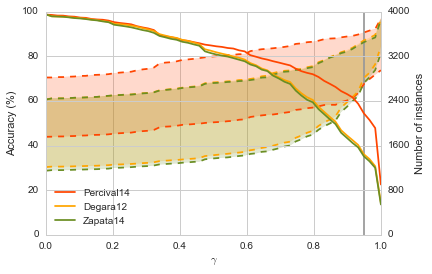


Confidence vs tempo estimation accuracy (APPL)
----------------------------------------------



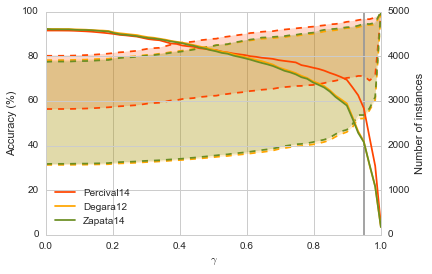


Confidence vs tempo estimation accuracy (MIXL)
----------------------------------------------



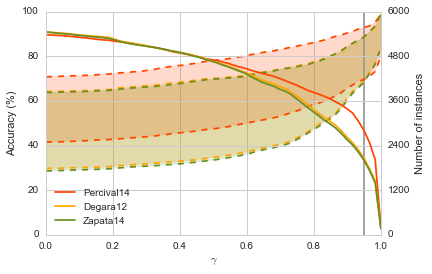


Confidence vs tempo estimation accuracy (LOOP)
----------------------------------------------



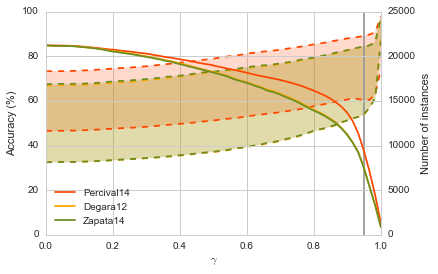

In [5]:
# Now do all the plotting

for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1) #, figsize=(14, 6)
    ax2 = ax1.twinx()
    methods_to_compare = ['Percival14_bpm', 'RE13d_bpm', 'RE13m_bpm']

    for count, method in enumerate(methods_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
            accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
            accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
            accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
            counts.append(len(filtered_data))
        
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=TEMPO_ESTIMATION_ALGORITHM_NAMES[method])

    print title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    fig.savefig(os.path.join(settings.TEMPO_ESTIMATION_OUT_PATH, 'accuracy_vs_confidence_%s.pdf' % dataset.short_name))
    plt.show()

In [6]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
methods_to_compare = ['rekordbox_bpm', 'Percival14_bpm', 'RE13d_bpm', 'RE13m_bpm', 'Madmom_bpm', 'Gkiokasq8_bpm']
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in methods_to_compare:
    table_row = list()
    table_row.append(TEMPO_ESTIMATION_ALGORITHM_NAMES[method])
    for dataset in datasets:
        filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_threshold)]).data
        min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
        max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)
print_table(table_header, table_rows)

Method       FSL4                      APPL                      MIXL                      LOOP                      
---------------------------------------------------------------------------------------------------------------------
RekBox       A=77.52 - 88.87%, N=34%   A=72.88 - 97.79%, N=37%   A=82.34 - 96.69%, N=27%   A=72.36 - 91.46%, N=26%   
Percival14   A=67.56 - 90.62%, N=55%   A=71.06 - 96.58%, N=61%   A=69.68 - 92.92%, N=51%   A=60.50 - 89.17%, N=44%   
Degara12     A=70.34 - 87.18%, N=37%   A=51.93 - 93.78%, N=45%   A=69.10 - 88.58%, N=38%   A=53.84 - 84.46%, N=35%   
Zapata14     A=68.07 - 86.34%, N=36%   A=53.56 - 94.49%, N=45%   A=68.38 - 88.69%, N=37%   A=53.94 - 84.45%, N=35%   
Bock15       A=49.06 - 87.69%, N=39%   A=56.78 - 90.39%, N=46%   A=53.74 - 86.61%, N=34%   A=56.02 - 84.12%, N=31%   
Gkiokas12    A=46.31 - 85.34%, N=28%   A=46.60 - 93.76%, N=46%   A=49.49 - 83.80%, N=31%   A=41.42 - 83.80%, N=35%   


In [9]:
# Run pairwise statistical tests when filtering by 95% confidence
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ""
    print title('Statistical tests for dataset %s' % dataset.short_name)    
    methods_to_compare = ['Gkiokasq8_bpm', 'RE13d_bpm', 'RE13m_bpm', 'Percival14_bpm','Madmom_bpm', 'rekordbox_bpm']
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print '\nMeasure: %s' % accuracy_func.__name__
        table_header = [' '] + [TEMPO_ESTIMATION_ALGORITHM_NAMES[method] for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    filtered_data_a = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    filtered_data_b = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    result = compute_mcnemar_test(accuracy_func(filtered_data_a, method_a), accuracy_func(filtered_data_b, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([TEMPO_ESTIMATION_ALGORITHM_NAMES[method_a]] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset FSL4
----------------------------------


Measure: accuracy1e
             Gkiokas12    Degara12    Zapata14    Percival14   Bock15       RekBox      
----------------------------------------------------------------------------------------
Gkiokas12    -            0.0368      0.915       1.05e-11*    4.59e-06*    0.0012*     
Degara12     4.02e-119*   -           1.49e-29*   1.72e-12*    3.36e-89*    1.35e-48*   
Zapata14     3.77e-113*   5.19e-15*   -           3.43e-09*    8.26e-85*    1.69e-43*   
Percival14   4.7e-177*    8.21e-86*   6.95e-97*   -            7.65e-125*   2.12e-69*   
Bock15       4.52e-63*    0.00488*    3.32e-08*   6.27e-11*    -            0.00168*    
RekBox       1.72e-125*   7.81e-72*   2.32e-77*   3.03e-23*    2.44e-100*   -           

Measure: accuracy1
             Gkiokas12   Degara12    Zapata14    Percival14   Bock15      RekBox      
--------------------------------------------------------------------------------------


## Combined accuracy and confidence measure

In [10]:
# NOTE: To run this cell, confidence measures need to be computed first (see cells above)

def overall_method_score(accuracies, counts, dataset_size):
    """
    We normalize the counts to the dataset size so scores provided by datasets of different sizes are comparable.
    We also normalize accuracy values to go from 0 to 1 instead of from 0 to 100.
    Finally we divide the result by the number of bins of the histogram so that using histograms of different resolution
    should return similar results.
    """
    overall_score = 0.0
    length = len(counts)  # Should be the same as len(accuracies)
    for i in range(length):
        overall_score += 2 * ((float(counts[i])/dataset_size) * (float(accuracies[i])/100)) / ((float(counts[i])/dataset_size) + (float(accuracies[i])/100))
    return overall_score/length

methods_to_compare = ['rekordbox_bpm', 'Percival14_bpm', 'RE13d_bpm', 'RE13m_bpm', 'Madmom_bpm', 'Gkiokasq8_bpm']
for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print title('Combined score results for %s' % accuracy_func.__name__)
    table_header = ['Method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method in methods_to_compare:
        table_row = list()
        table_row.append(TEMPO_ESTIMATION_ALGORITHM_NAMES[method])
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method       FSL4   APPL   MIXL   LOOP   
-----------------------------------------
Percival14   0.62   0.71   0.60   0.62   
RekBox       0.53   0.57   0.47   0.53   
Degara12     0.49   0.49   0.49   0.50   
Zapata14     0.47   0.50   0.47   0.50   
Bock15       0.41   0.53   0.38   0.49   
Gkiokas12    0.34   0.45   0.34   0.42   

Combined score results for accuracy1
------------------------------------

Method       FSL4   APPL   MIXL   LOOP   
-----------------------------------------
Percival14   0.70   0.80   0.68   0.69   
Degara12     0.66   0.76   0.65   0.69   
Zapata14     0.65   0.76   0.65   0.69   
RekBox       0.57   0.65   0.52   0.57   
Bock15       0.53   0.62   0.54   0.61   
Gkiokas12    0.51   0.71   0.53   0.58   

Combined score results for accuracy2
------------------------------------

Method       FSL4   APPL   MIXL   LOOP   
-----------------------------------------
Percival14   0

## Comparisson with confidence measure from Zapata14


Confidence vs tempo estimation accuracy (FSL4)
----------------------------------------------



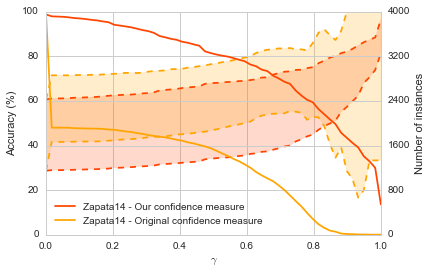


Confidence vs tempo estimation accuracy (APPL)
----------------------------------------------



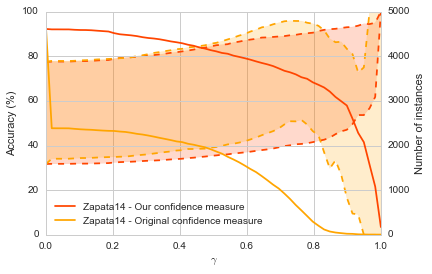


Confidence vs tempo estimation accuracy (MIXL)
----------------------------------------------



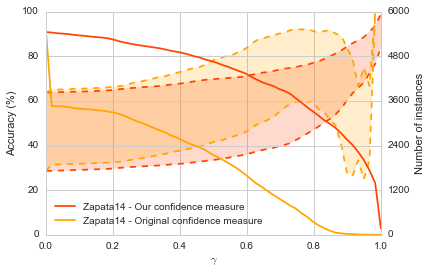


Confidence vs tempo estimation accuracy (LOOP)
----------------------------------------------



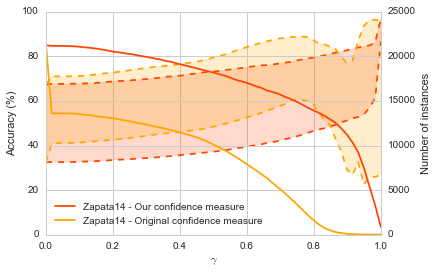

In [11]:
# Normalize confidence measure for Zapata14 so that numbers go from 0 to 1 and it is
# comparable with our confidence measure. We get the maximum and minimum value found in the dataset 
# and normalise the confidence to be in the [0, 1] range.


for dataset in datasets:
    methods_to_compare = ['Gkiokasq8_bpm', 'RE13d_bpm', 'RE13m_bpm', 'Percival14_bpm','Madmom_bpm', 'rekordbox_bpm']
    
    # Annotate all methods wirh confidence measures using the function above
    zapata_conf_values = dataset.get_data('analysis.RE13m_bpm.confidence')
    max_value = max(zapata_conf_values)
    min_value = min(zapata_conf_values)
    for key, item in dataset.data.items():
        normalised_value = float(item['analysis']['RE13m_bpm']['confidence'] - min_value)/(max_value - min_value)
        item['analysis']['RE13m_bpm']['confidence_zapata'] = normalised_value

        
CONFIDENCE_MEASURE_NAMES = {
    'confidence_ffont': 'Our confidence measure',
    'confidence_zapata': 'Original confidence measure'
}
        
for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1) # , figsize=(14, 6)
    ax2 = ax1.twinx()
    methods_to_compare = [('RE13m_bpm', 'confidence_ffont'), 
                          ('RE13m_bpm', 'confidence_zapata')]
   
    for count, (method, conf_method) in enumerate(methods_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
            accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
            accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
            accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
            counts.append(len(filtered_data))
        
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, 
                         color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label="%s - %s" % (TEMPO_ESTIMATION_ALGORITHM_NAMES[method], CONFIDENCE_MEASURE_NAMES[conf_method]))

    print title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    fig.savefig(os.path.join(settings.TEMPO_ESTIMATION_OUT_PATH, 'confidence_ffont_vs_confidence_zapata_%s.pdf' % dataset.short_name))
    plt.show()

In [12]:
# Compute combined scores for Zapata14 method using confidence_ffont or confidence_zapata
# NOTE: to run this cell 'overall_method_score' must have been defined (see cells above)

methods_to_compare = [('RE13m_bpm', 'confidence_ffont'), 
                      ('RE13m_bpm', 'confidence_zapata')]
for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print title('Combined score results for %s' % accuracy_func.__name__)
    table_header = ['Method - Conf method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method, conf_method in methods_to_compare:
        table_row = list()
        table_row.append('%s - %s' % (TEMPO_ESTIMATION_ALGORITHM_NAMES[method], conf_method))
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
                accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method - Conf method           FSL4   APPL   MIXL   LOOP   
-----------------------------------------------------------
Zapata14 - confidence_ffont    0.47   0.50   0.47   0.50   
Zapata14 - confidence_zapata   0.32   0.30   0.30   0.36   

Combined score results for accuracy1
------------------------------------

Method - Conf method           FSL4   APPL   MIXL   LOOP   
-----------------------------------------------------------
Zapata14 - confidence_ffont    0.65   0.76   0.65   0.69   
Zapata14 - confidence_zapata   0.38   0.39   0.38   0.44   

Combined score results for accuracy2
------------------------------------

Method - Conf method           FSL4   APPL   MIXL   LOOP   
-----------------------------------------------------------
Zapata14 - confidence_ffont    0.70   0.82   0.71   0.74   
Zapata14 - confidence_zapata   0.40   0.43   0.42   0.46   
